# House Prices: Advanced Regression Techniques

In [264]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [256]:
all_train_set = pd.read_csv('data/train.csv', index_col='Id')
all_test_set = pd.read_csv('data/test.csv', index_col='Id')

## Sale Price Distribution

/Users/zstewart/ml-group/House-Prices/venv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


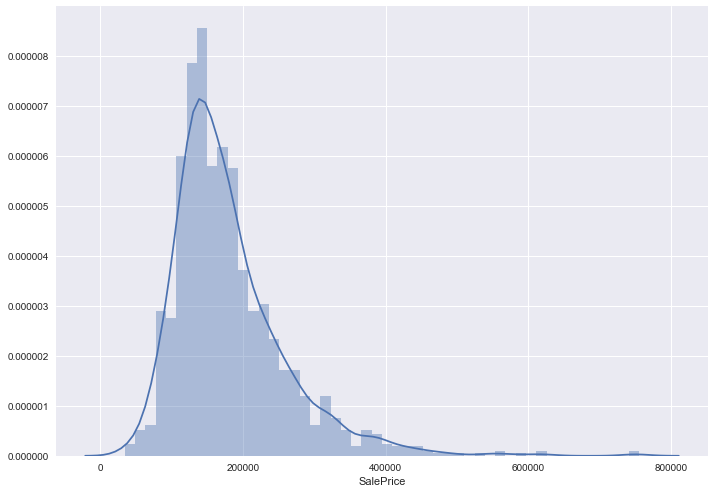

In [257]:
sns.distplot(all_train_set.SalePrice, bins=50);

## Log Transformed Sale Price Distribution

In [258]:
all_train_set['LogSalePrice'] = np.log1p(all_train_set.SalePrice)

/Users/zstewart/ml-group/House-Prices/venv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


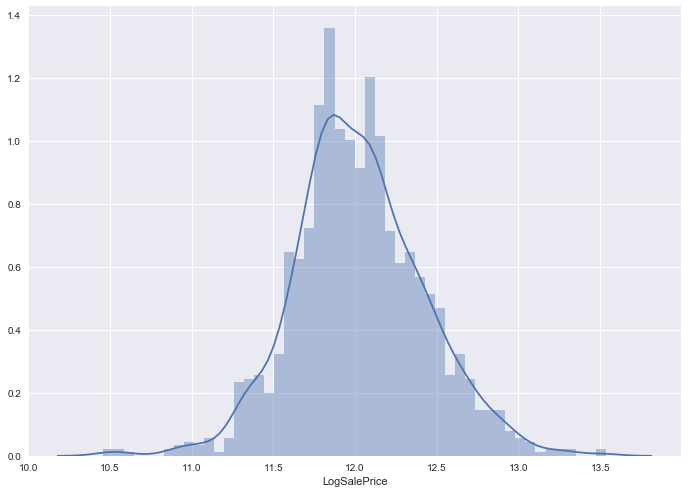

In [259]:
sns.distplot(all_train_set.LogSalePrice, bins = 50);

## Features

In [260]:
all_train_set.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LogSalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.247699
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.109016
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12.317171
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,11.849405
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,12.429220


### Continuous

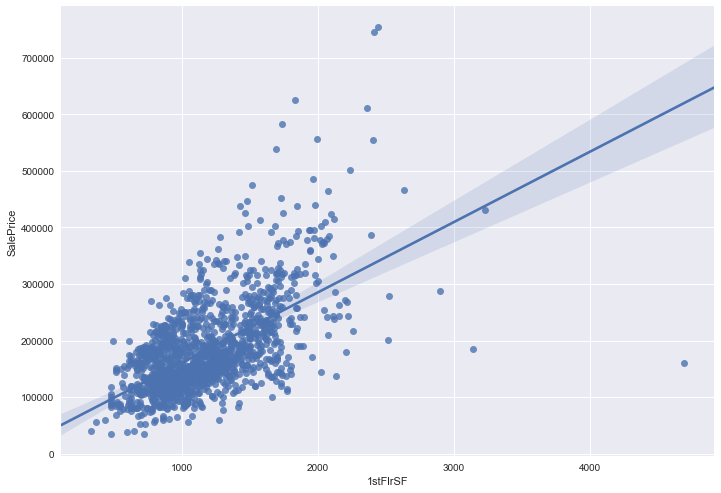

In [261]:
sns.regplot(data=all_train_set, x="1stFlrSF", y="SalePrice")

### Discrete

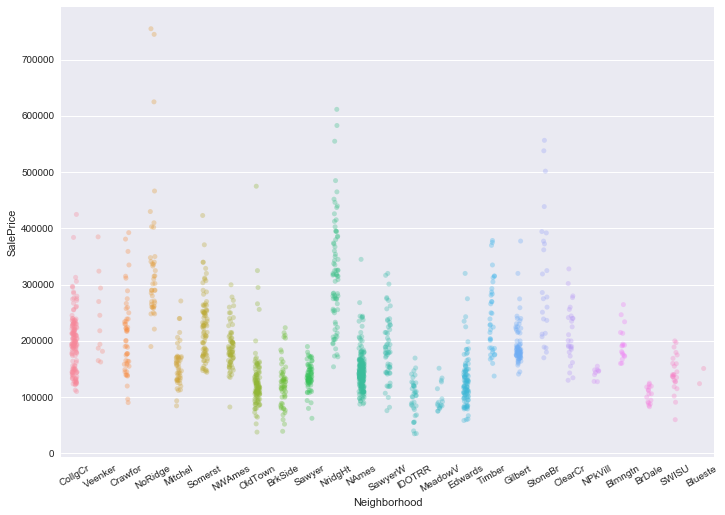

In [262]:
fig = sns.stripplot(data=all_train_set, x="Neighborhood", y="SalePrice", jitter=True, alpha=.33);
fig.set_xticklabels(fig.get_xticklabels(), rotation=30)
fig

### Feature Correlation

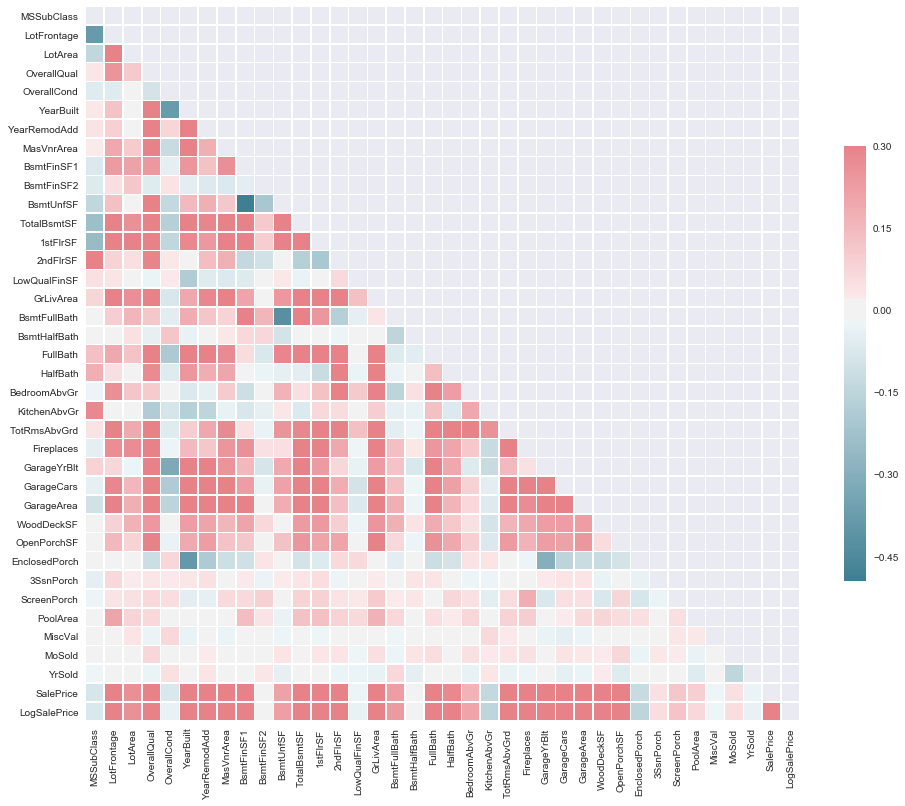

In [263]:
correlation = all_train_set.corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(16, 16))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [247]:
correlation['SalePrice'].drop(['SalePrice', 'LogSalePrice']).idxmax()

'OverallQual'

## Validate a Model

In [130]:
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from collections import defaultdict

In [120]:
class YearAndMonthTransformer(TransformerMixin):
    def __init__(self, year='YrSold', month='MoSold'):
        self.year = year
        self.month = month
        
    def fit(self, X, y=None, **fit_params):
        min_year = X[self.year].min()
        min_month = X[self.month].min()
        self.base_months = min_year * 12 + min_month
        return self 
    
    def transform(self, X, **transform_params):
        months = X[self.month].tolist()
        years = X[self.year].tolist()
        combined = []
        for (year, month) in zip(years, months):
            combined.append(year * 12 + month - self.base_months)
            
        return np.asarray(combined).reshape(len(combined), 1)

YearAndMonthTransformer().fit_transform(all_train_set).shape

(1460, 1)

In [312]:
class ColumnSelector(TransformerMixin):
    
    def __init__(self, columns=[]):
        self.columns = columns
        
    def fit(self, X, y, **fit_params):
        return self
        
    def transform(self, X, **transform_params):
        return X[self.columns]
    

class FillNaTransformer(TransformerMixin):
    
    def __init__(self, fill_with):
        self.fill_with = fill_with
        
    def fit(self, X, y, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        return X.fillna(self.fill_with)
    

class DebugTransformer(TransformerMixin):
    def fit(self, X, y):
        print("fit")
        print(X)
        print(y)
        return self
        
    def transform(self, X, y=None):
        print("transform")
        print(X)
        print(y) 
        return X
    
class ToDictTransformer(TransformerMixin):

    def fit(self, *_):
        return self

    def transform(self, X, **transform_params):
        return X.to_dict(orient='records')
    

def factor_feature(name):
    return (name, Pipeline([
        ('extract', ColumnSelector([name])),
        ('fill_na', FillNaTransformer(0.0)),
        ('to_dict', ToDictTransformer()),
        ('label', DictVectorizer(sparse=False))
    ]))

def continuous_feature(name, default_value=0.0):
    return (name, Pipeline([
        ('extract', ColumnSelector([name])),
        ('fill_na', FillNaTransformer(default_value))
    ]))

In [313]:
regressors = [GradientBoostingRegressor(), Lasso(), ElasticNet(), Ridge()]
comparison = defaultdict(list)
comparison['truth'].extend(all_train_set['LogSalePrice'].data)

for regressor in regressors:
    regressor_name = model.steps[-1][1].__class__.__name__
    
    print('---', regressor_name, '----')
    
    model = Pipeline([
        ('features', FeatureUnion([
            continuous_feature('LotArea'),
            continuous_feature('YearBuilt'),
            continuous_feature('YearRemodAdd'),
            continuous_feature('BsmtFinSF1'),
            continuous_feature('BsmtFinSF2'),
            continuous_feature('BsmtUnfSF'),
            continuous_feature('TotalBsmtSF'),  # may be redundant
            continuous_feature('1stFlrSF'),
            continuous_feature('2ndFlrSF'),
            continuous_feature('LowQualFinSF'),
            continuous_feature('GrLivArea'),
            continuous_feature('BsmtFullBath'),
            continuous_feature('FullBath'),
            continuous_feature('HalfBath'),
            continuous_feature('BedroomAbvGr'),
            continuous_feature('KitchenAbvGr'),
            continuous_feature('TotRmsAbvGrd'),
            continuous_feature('Fireplaces'),
            continuous_feature('GarageYrBlt'),
            continuous_feature('GarageCars'),
            continuous_feature('GarageArea'),
            continuous_feature('LotFrontage'),
            continuous_feature('MasVnrArea'),
            continuous_feature('WoodDeckSF'),
            continuous_feature('OpenPorchSF'),
            continuous_feature('EnclosedPorch'),
            continuous_feature('3SsnPorch'),
            continuous_feature('ScreenPorch'),
            continuous_feature('PoolArea'),
            continuous_feature('MiscVal'),

            ## Categorical
            ('MSSubClass', Pipeline([
                ('extract', ColumnSelector(['MSSubClass'])),
                ('one_hot', OneHotEncoder())
            ])),

            factor_feature('MSZoning'),
            factor_feature('Street'),
            factor_feature('Alley'),
            factor_feature('LotShape'),
            factor_feature('LandContour'),
            factor_feature('Utilities'),
            factor_feature('LotConfig'),
            factor_feature('LandSlope'),
            factor_feature('Neighborhood'),
            factor_feature('Condition1'),
            factor_feature('Condition2'),
            factor_feature('BldgType'),
            factor_feature('HouseStyle'),
            factor_feature('OverallQual'),
            factor_feature('OverallCond'),
            factor_feature('RoofStyle'),
            factor_feature('RoofMatl'),
            factor_feature('Exterior1st'),
            factor_feature('Exterior2nd'),
            factor_feature('MasVnrType'),
            factor_feature('ExterQual'),
            factor_feature('ExterCond'),
            factor_feature('Foundation'),
            factor_feature('BsmtQual'),
            factor_feature('BsmtCond'),
            factor_feature('BsmtExposure'),
            factor_feature('BsmtFinType1'),
            factor_feature('Heating'),
            factor_feature('HeatingQC'),
            factor_feature('CentralAir'),
            factor_feature('Electrical'),
            factor_feature('KitchenQual'),
            factor_feature('Functional'),
            factor_feature('FireplaceQu'),
            factor_feature('GarageType'),
            factor_feature('GarageFinish'),
            factor_feature('GarageQual'),
            factor_feature('GarageCond'),
            factor_feature('PavedDrive'),
            factor_feature('PoolQC'),
            factor_feature('Fence'),
            factor_feature('MiscFeature'),
            factor_feature('SaleType'),
            factor_feature('SaleCondition'),

            ('YearAndMonth', YearAndMonthTransformer())

        ])),
        ('regressor', regressor)
    ])

    kfold = KFold(5)
    np.random.seed(0)
    rmses = []

    for (train_idx, cv_idx) in kfold.split(all_train_set):
        construct = all_train_set.iloc[train_idx]
        validate = all_train_set.iloc[cv_idx]

        construct_X = construct
        construct_y = construct['LogSalePrice']

        validate_X = validate
        validate_y = validate['LogSalePrice']

        model.fit(construct_X, y=construct_y)
        predictions = model.predict(validate_X)
        rmse = np.sqrt(mean_squared_error(np.expm1(validate_y), np.expm1(predictions)))
        rmses.append(rmse)
        print(rmse)

        comparison[regressor_name].extend(predictions)

    print('mean', np.mean(rmses), '\n')

--- Ridge ----
23090.29126544094
30437.243697402733
30526.498601792537
21373.687386261932
27983.783070752383
mean 26682.300804330105 

--- GradientBoostingRegressor ----
32644.212220552057
58524.08525457706
35047.584941933135
33741.63484694913
297454.7934239855
mean 91482.46213759937 

--- Lasso ----
31242.449447709627
58070.693561089734
32917.787435037644
32317.7410109613
266964.01669629826
mean 84302.53763021932 

--- ElasticNet ----
40968.01802443837
67965.16567313785
44480.05082516513
40880.959105360445
335134.0913346746
mean 105885.65699255528 



In [177]:
df = pd.DataFrame(columns=['order', 'value', 'source'])
sorted_indices = np.argsort(comparison['truth'])

for (name, preds) in comparison.items():
    df = df.append([
        dict(order=i, value=p, source=name)
        for (i, p) in enumerate(np.asarray(preds)[sorted_indices])])

In [196]:
df['Truth'] = df['source'] == 'truth'

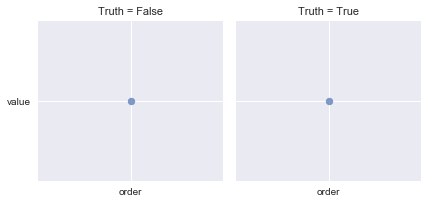

In [203]:
g = sns.FacetGrid(df, col="Truth")
g.map(plot.scatter, x='order', y='value', alpha=.7)
g.add_legend();
# sns.stripplot(data=df, x='order', y='value', hue='Truth', alpha=0.1)

In [178]:
df.source.unique()

array(['truth', 'GradientBoostingRegressor', 'Lasso', 'ElasticNet',
       'Ridge'], dtype=object)

## Make a Submission

In [10]:
model.fit(all_train_set, y=all_train_set['SalePrice'])

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('LotArea', Pipeline(memory=None,
     steps=[('extract', <__main__.ColumnSelector object at 0x10ca0a940>), ('fill_na', <__main__.FillNaTransformer object at 0x10ca0a978>)])), ('YearBuilt', Pipeline(memory=None,
     steps=[('extrac...s=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))])

In [11]:
predictions = model.predict(all_test_set)

In [12]:
predictions

array([118999.6314348 , 157403.35824132, 186154.82394311, ...,
       166937.45049332, 134141.17259573, 228159.66078908])

In [13]:
submission = pd.DataFrame({'Id': all_test_set['Id'], 'SalePrice': predictions})

In [51]:
submission.to_csv('submission.csv', index=False)